### Optimisation of positioning of the turbine
This notebook will look to optimise the positioning of the turbine to provide maximum power output allowing for variation in position (and eventually RPM, and other design parameters)

In [2]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from breastshot_calcs import breastTurbine
from river_class import river_obj
from undershot_calcs import underTurbine
from pyswarms.single.global_best import GlobalBestPSO
from pyswarm import pso

# Full optimisation workbook

This optimisation workbook will attempt to provide a region of best performance in the multi-dimensional parameter space of the turbine design features and installation sensitivities.

In [3]:
'''
the breastshot turbine is optimised first:

the objective function is the power output of the turbine as given by the analysis function

the constraints are detailed for each variable in the dictionary above

this is a large non-linear optimisation problem and so Particle Swarm Optimisation is used

'''

b_river = river_obj(width=2, depth=2, velocity=1.5, head=2)

# use pyswarms to set up the optimisation problem

num_particles = 200
dims = 6
options = {'c1': 0.7, 'c2': 0.5, 'w':0.9}

mins = [0.4, 0.5, 3, 0.4, -b_river.head, 1]
maxs = [2, 1.5, 21, 3, 1, 40]
bounds = (mins, maxs)

print(dims, bounds)

b_turbine = breastTurbine(b_river)

# define the objective function
def fun(x):
    b_turbine.t_radius = x[0]
    b_turbine.t_width = x[1]
    b_turbine.t_num_blades = x[2]
    b_turbine.t_x_centre = x[3]
    b_turbine.t_y_centre = x[4]
    b_turbine.t_RPM = x[5]
    return -b_turbine.analysis()



# define optimiser

optimiser = GlobalBestPSO(n_particles=num_particles, dimensions=dims, options=options, bounds=bounds)

# run optimisation
cost, pos = optimiser.optimize(fun, iters=100)

# pos, cost = pso(fun, mins, maxs, swarmsize=100, maxiter=100)



2023-04-13 17:14:10,016 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.9}


6 ([0.4, 0.5, 3, 0.4, -2, 1], [2, 1.5, 21, 3, 1, 40])


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-2.11e+3
2023-04-13 17:14:14,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2113.6747768651194, best pos: [ 0.69375334  0.85127226  3.63124649  0.93053474 -0.55836941 18.10150902]


In [17]:
# show the results
print(cost, pos)

# create a new turbine object with the optimised parameters
b_turbine.t_radius = pos[0]
b_turbine.t_width = pos[1]
b_turbine.t_num_blades = pos[2]
b_turbine.t_x_centre = pos[3]
b_turbine.t_y_centre = pos[4]
b_turbine.t_RPM = pos[5]

# run the analysis again
b_turbine.analysis()

print('num blades: ', np.round(b_turbine.t_num_blades, 0))



-2113.6747768651194 [ 0.69369169  0.85127215  3.63124641  0.93053469 -0.55837063 18.10150902]
num blender blades:  4.0


In [18]:
# now repeat the optimisation for a range of river velocities

# define the range of velocities
velocities = np.linspace(0.5, 10, 10)

# create a dataframe to store the results
b_results = pd.DataFrame(columns=['flow rate', 'power', 'radius', 'width', 'num_blades', 'x_centre', 'y_centre', 'RPM'])

# loop through the velocities
for velocity in velocities:
    # create a new river object
    b_river = river_obj(width=0.77, depth=0.3, velocity=velocity, head=1)
    # create a new turbine object
    b_turbine = breastTurbine(b_river)
    # run the optimisation
    cost, pos = optimiser.optimize(fun, iters=100)
    # store the results
    b_results = b_results.append({'flow rate': b_river.vol_flow_rate, 'power': -cost, 'radius': pos[0], 'width': pos[1], 'num_blades': np.round(pos[2],0), 'x_centre': pos[3], 'y_centre': pos[4], 'RPM': pos[5]}, ignore_index=True)



2023-04-13 17:19:23,296 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-2.11e+3
2023-04-13 17:19:28,407 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2113.6747768651194, best pos: [ 0.69362644  0.8512721   3.63124644  0.93053473 -0.55836898 18.10150902]
/var/folders/4d/1cd5pk9s6f7_prxws19jm1fw0000gn/T/ipykernel_68411/1036461354.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  b_results = b_results.append({'flow rate': b_river.vol_flow_rate, 'power': -cost, 'radius': pos[0], 'width': pos[1], 'num_blades': np.round(pos[2],0), 'x_centre': pos[3], 'y_centre': pos[4], 'RPM': pos[5]}, ignore_index=True)
2023-04-13 17:19:28,420 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100

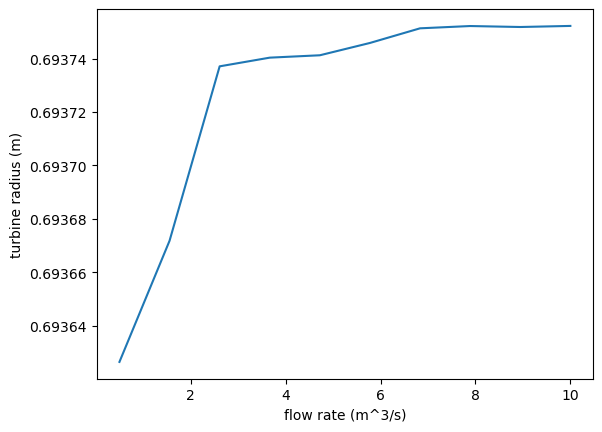

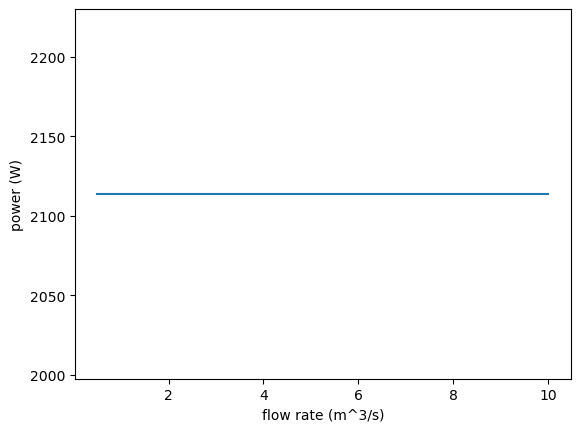

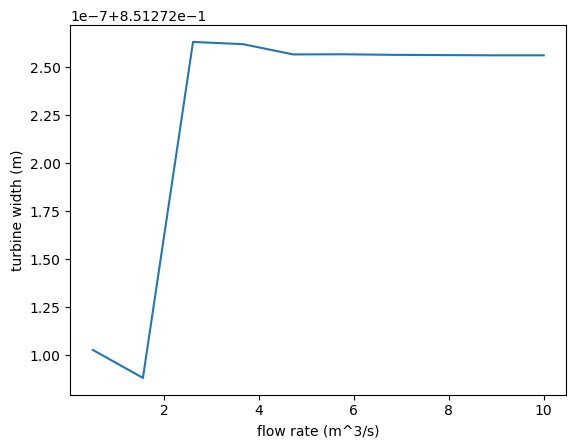

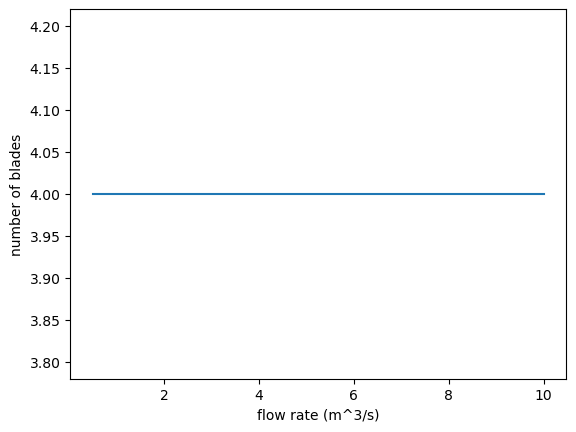

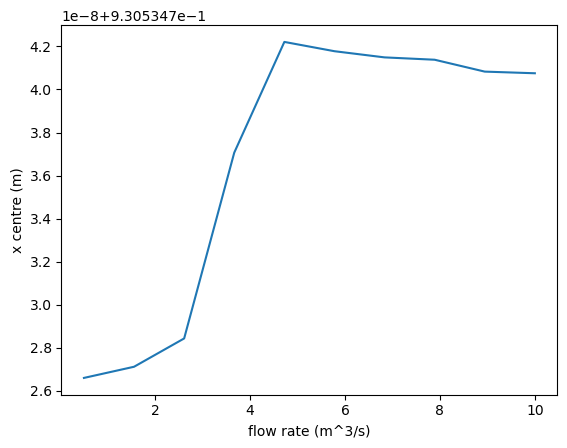

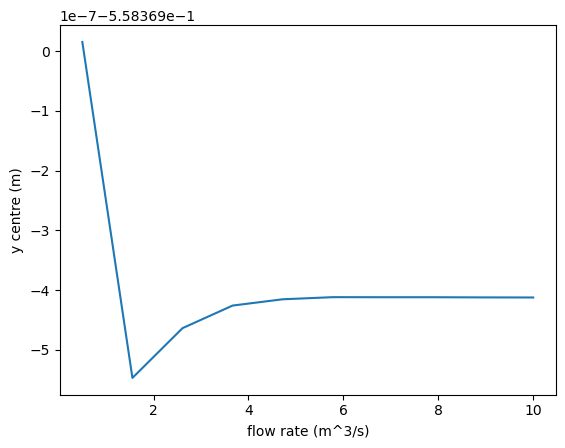

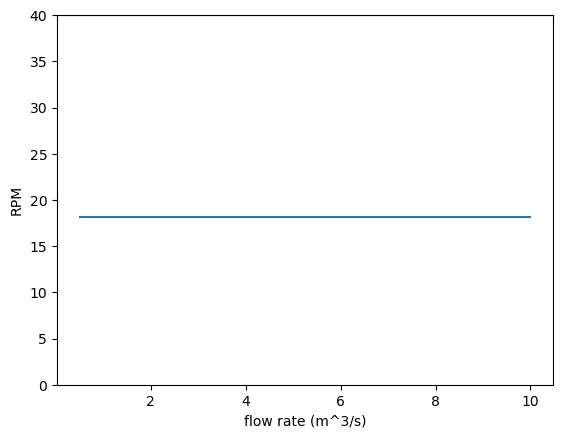

In [25]:
# plot the results radius vs flow rate
plt.plot(b_results['flow rate'], b_results['radius'])
plt.xlabel('flow rate (m^3/s)')
plt.ylabel('turbine radius (m)')
plt.show()

# plot the results power vs flow rate
plt.plot(b_results['flow rate'], b_results['power'])
plt.xlabel('flow rate (m^3/s)')
plt.ylabel('power (W)')
plt.show()

# plot the width vs flow rate
plt.plot(b_results['flow rate'], b_results['width'])
plt.xlabel('flow rate (m^3/s)')
plt.ylabel('turbine width (m)')
plt.show()

# plot the number of blades vs flow rate
plt.plot(b_results['flow rate'], b_results['num_blades'])
plt.xlabel('flow rate (m^3/s)')
plt.ylabel('number of blades')
plt.show()

# plot the x centre vs flow rate
plt.plot(b_results['flow rate'], b_results['x_centre'])
plt.xlabel('flow rate (m^3/s)')
plt.ylabel('x centre (m)')
plt.show()

# plot the y centre vs flow rate
plt.plot(b_results['flow rate'], b_results['y_centre'])
plt.xlabel('flow rate (m^3/s)')
plt.ylabel('y centre (m)')
plt.show()

# plot the RPM vs flow rate
plt.plot(b_results['flow rate'], b_results['RPM'])
plt.xlabel('flow rate (m^3/s)')
plt.ylabel('RPM')
# make the y labels integers
plt.yticks(np.arange(0, 41, 5)) 
plt.show()



